# Example 9: Quarter wavelength site amplification

Example of quarter-wavelength site amplification and fitting a profile to a target crustal amplification.

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

Load the WNA profile from Campbell (2003).

In [3]:
with open('../tests/data/qwl_tests.json') as fp:
    data = json.load(fp)[1]
    
thickness = np.diff(data['site']['depth'])

profile = pysra.site.Profile()
for i, (thick, vel_shear, density) in enumerate(zip(
    thickness, data['site']['velocity'], data['site']['density']
)):
    profile.append(
        pysra.site.Layer(
            pysra.site.SoilType(f'{i}', density * pysra.motion.GRAVITY),
            thick * 1000, vel_shear * 1000,
        )
    )

profile.update_layers(0)

Create simple point source motion

In [4]:
motion = pysra.motion.SourceTheoryRvtMotion(
    magnitude=6.5, distance=20, region='cena'
)
motion.calc_fourier_amps(data['freqs'])

In [5]:
calc = pysra.propagation.QuarterWaveLenCalculator(site_atten=0.04)
input_loc = profile.location('outcrop', index=-1)

In [6]:
calc(motion, profile, input_loc)

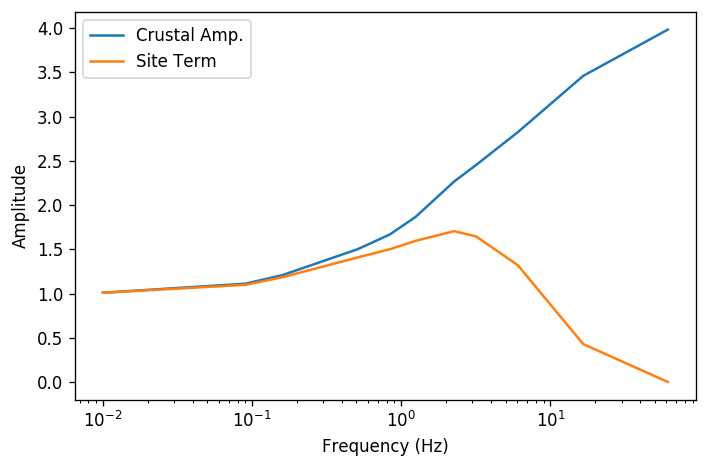

In [7]:
fig, ax = plt.subplots()
ax.plot(motion.freqs, calc.crustal_amp, label='Crustal Amp.')
ax.plot(motion.freqs, calc.site_term, label='Site Term')
ax.set(
    xlabel='Frequency (Hz)', xscale='log',
    ylabel='Amplitude', yscale='linear',
)
ax.legend()
fig.tight_layout();

The quarter-wavelength calculation is tested against the WNA and CENA crustal amplification models provided by Campbell (2003). The test of the CENA model passes, but the WNA model fails. Below is a comparison of the two crustal amplifications.

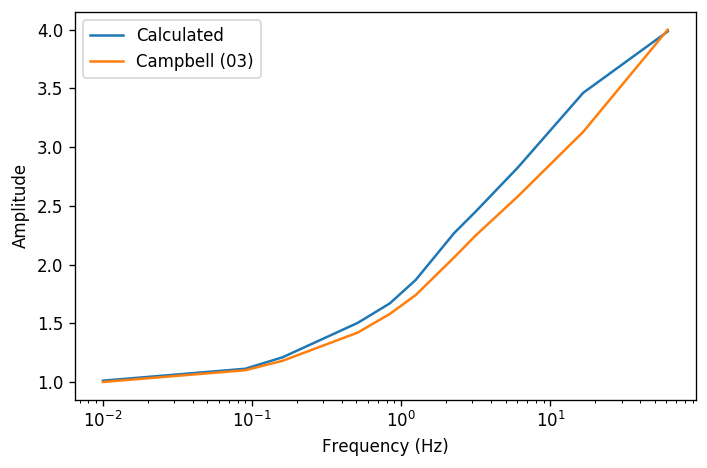

In [8]:
fig, ax = plt.subplots()
ax.plot(motion.freqs, calc.crustal_amp, label='Calculated')
ax.plot(data['freqs'], data['crustal_amp'], label='Campbell (03)')
ax.set(
    xlabel='Frequency (Hz)', xscale='log',
    ylabel='Amplitude', yscale='linear',
)
ax.legend()
fig.tight_layout();

Adjust the profile to match the target crustal amplification -- no consideration of the site attenuation paramater although this can also be done. First, the adjustment is only performed on the velocity. Second set of plots adjusts velocity and thickness.

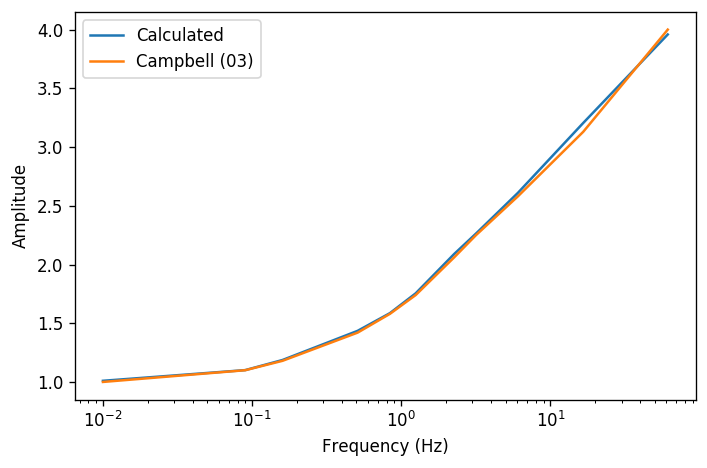

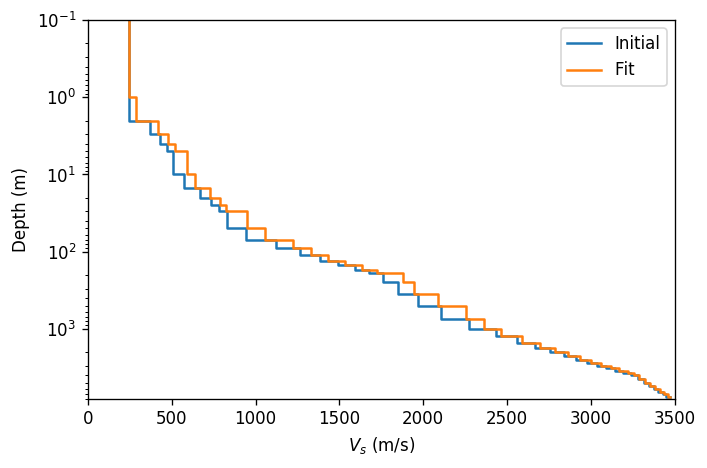

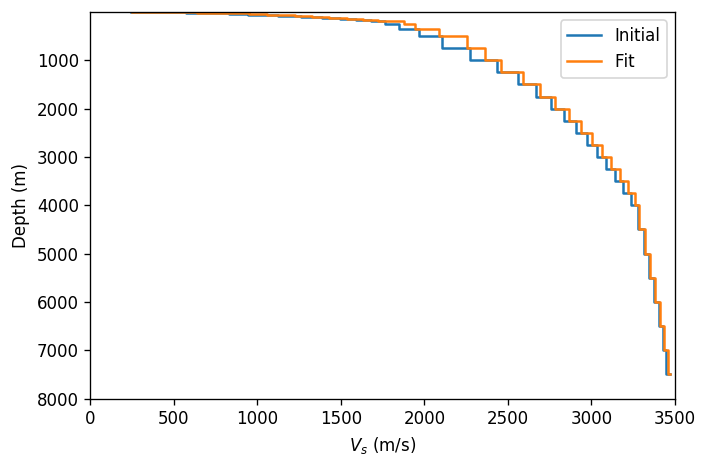

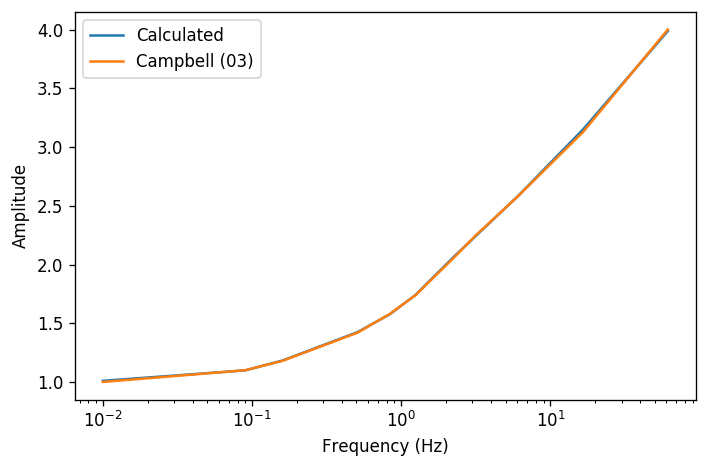

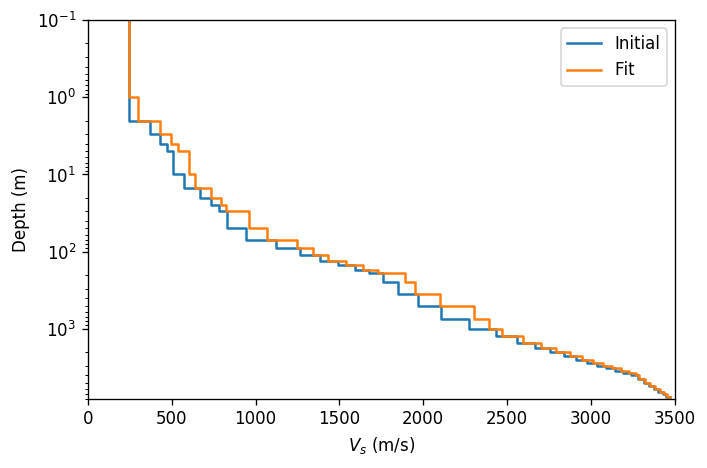

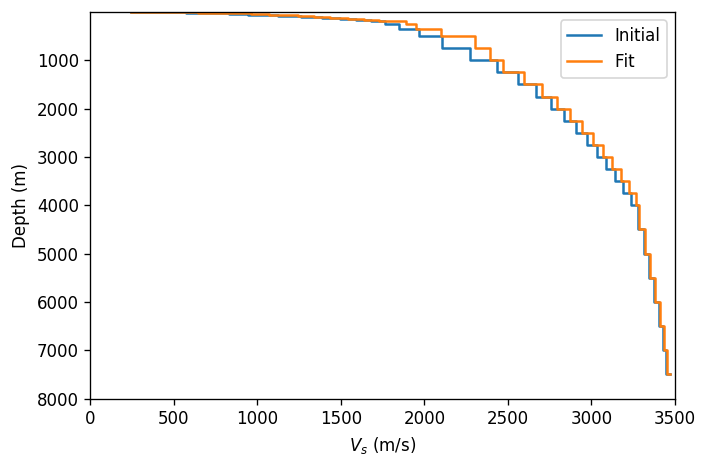

In [9]:
for adjust_thickness in [False, True]:
    calc.fit(target_type='crustal_amp', target=data['crustal_amp'], 
                      adjust_thickness=adjust_thickness)
    
    fig, ax = plt.subplots()
    ax.plot(motion.freqs, calc.crustal_amp, label='Calculated')
    ax.plot(data['freqs'], data['crustal_amp'], label='Campbell (03)')
    ax.set(
        xlabel='Frequency (Hz)', xscale='log',
        ylabel='Amplitude', yscale='linear',
    )
    ax.legend()
    fig.tight_layout();
    
    for yscale in ['log', 'linear']:
        fig, ax = plt.subplots()

        ax.plot(profile.initial_shear_vel, profile.depth,
                label='Initial', drawstyle='steps-pre')
        ax.plot(calc.profile.initial_shear_vel, calc.profile.depth,
                label='Fit', drawstyle='steps-pre')

        ax.legend()
        ax.set(
            xlabel='$V_s$ (m/s)', xlim=(0, 3500), 
            ylabel='Depth (m)', ylim=(8000, 0.1), yscale=yscale,
        )
        fig.tight_layout();